# 1. Estimate flow channel concentration    

This notebook uses analytical 1D reaction-diffusion model to simulate gradients in coupled family machine to calculate exogenous concentration to add in PA flow channel to complement (i.e. restore) PA-WT like-gradients in PA double mutant conditions. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import seaborn as sns
from pathlib import Path

def coth(z):
    """
    Numerically stable coth(z) = cosh(z)/sinh(z); handle small z with series
    
    Parameters:
    -----------
    z : array_like
        Input values
        
    Returns:
    --------
    array_like
        Hyperbolic cotangent values
    """
    z = np.asarray(z, dtype=float)
    out = np.empty_like(z)
    small = np.abs(z) < 1e-6
    if np.any(~small):
        out[~small] = np.cosh(z[~small]) / np.sinh(z[~small])
    if np.any(small):
        # series: coth z ~ 1/z + z/3 for small z
        out[small] = 1.0 / z[small] + z[small] / 3.0
    return out if out.shape else out.item()

def c_in_from_params(params):
    """
    Calculate c_in from parameter dictionary using no-producer formula:
    c_in = c0 * [1 + k * coth(kL) * (L + d/alpha)]
    
    Parameters:
    -----------
    params : dict
        Dictionary with keys: 'c0', 'A', 'L', 'd', 'W', 'W_gap'
        
    Returns:
    --------
    float
        Inlet concentration c_in
    """
    c0 = params['c0']
    A = params['A']
    L = params['L']
    d = params['d']
    W = params['W']
    W_gap = params['W_gap']
    
    alpha = W_gap / W
    k = np.sqrt(A)
    return c0 * (1.0 + k * coth(k * L) * (L + d / alpha))

def calculate_c_in_from_dataframe(df, c0_col='c0', A_col='A', 
                                 L=50.0, d=3.0, W=50.0, W_gap=12.5,
                                 percentiles=[5, 25, 50, 75, 95]):
    """
    Calculate c_in for each row in dataframe and return percentile statistics.
    
    This function preserves correlations between parameters by using paired
    observations from the dataframe rather than sampling from independent distributions.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame with columns for c0 and A parameters (one row per observation)
    c0_col : str, optional
        Column name for c0 parameter (default: 'c0')
    A_col : str, optional
        Column name for A parameter (default: 'A')
    L : float, optional
        Chamber length in µm (default: 50.0)
    d : float, optional
        Gap length in µm (default: 3.0)
    W : float, optional
        Chamber width in µm (default: 50.0)
    W_gap : float, optional
        Gap width in µm (default: 12.5)
    percentiles : list, optional
        Percentiles to calculate for output (default: [5, 25, 50, 75, 95])
        
    Returns:
    --------
    dict
        Dictionary with 'values' (all c_in values) and 'percentiles' keys

    """
    # Validate inputs
    if c0_col not in df.columns:
        raise ValueError(f"Column '{c0_col}' not found in dataframe")
    if A_col not in df.columns:
        raise ValueError(f"Column '{A_col}' not found in dataframe")
    
    # Calculate c_in for each row
    c_in_values = []
    
    for _, row in df.iterrows():
        params = {
            'c0': row[c0_col],
            'A': row[A_col],
            'L': L,
            'd': d,
            'W': W,
            'W_gap': W_gap
        }
        c_in_values.append(c_in_from_params(params))
    
    c_in_values = np.array(c_in_values)
    
    # Calculate percentiles
    percentile_results = {}
    for p in percentiles:
        percentile_results[p] = np.percentile(c_in_values, p)
    
    return {
        'values': c_in_values,
        'percentiles': percentile_results,
        'n_observations': len(c_in_values)
    }

def build_profile_from_params(params, nx=1200):
    """
    Build concentration profile c(x) from parameter dictionary.
    
    Parameters:
    -----------
    params : dict
        Dictionary with keys: 'c0', 'A', 'L', 'd', 'W', 'W_gap'
    nx : int, optional
        Number of spatial points
        
    Returns:
    --------
    tuple
        (x, c, c_in) where x is position array, c is concentration array, 
        c_in is inlet concentration
    """
    c0 = params['c0']
    A = params['A']
    L = params['L']
    d = params['d']
    W = params['W']
    W_gap = params['W_gap']
    
    alpha = W_gap / W
    k = np.sqrt(A)
    M = c0 / np.sinh(k * L)
    a2 = -(W / W_gap) * k * c0 * coth(k * L)
    a1 = -k * c0 * coth(k * L)
    b2 = c0 - a2 * (L + d)
    c_in = c_in_from_params(params)

    x = np.linspace(0.0, 2.0 * L + d, nx)
    c = np.zeros_like(x)

    m1 = x < L
    m2 = (x >= L) & (x < L + d)
    m3 = x >= L + d

    c[m1] = a1 * x[m1] + c_in
    c[m2] = a2 * x[m2] + b2
    c[m3] = M * np.sinh(k * (2.0 * L + d - x[m3]))

    return x, c, c_in

def plot_profile(ax, params, **plot_kwargs):
    """
    Plot concentration profile on specified axes object.
    
    Parameters:
    -----------
    ax : matplotlib.axes.Axes
        Axes object to plot on
    params : dict
        Parameter dictionary with keys: 'c0', 'A', 'L', 'd', 'W', 'W_gap'
    **plot_kwargs : dict
        Additional keyword arguments for plt.plot() (e.g., color, label, linestyle, linewidth)
        
    Returns:
    --------
    tuple
        (line, x, c, c_in) where line is the plotted line object, x is position array,
        c is concentration array, c_in is inlet concentration
    """
    x, c, c_in = build_profile_from_params(params)

    x = x - params['L'] - params['d']/2

    ax.plot(x, c, linewidth=2, label="c(x)", color='blue')
    ax.axvline(params['d']/2, color="k", linestyle="--", linewidth=1, label="x = L")
    ax.axvline(-params['d']/2, color="k", linestyle="--", linewidth=1, label="x = L + d")

    ax.set_xlim(-params['L'] - params['d'], params['L'] + params['d'])
    ax.set_xticks([-params['L'] - params['d']/2, 0, params['L'] + params['d']/2])
    ax.set_xlabel("Position x [µm]")
    # markers for c_in and c_0
    ax.plot(params['d']/2, params['c0'], "o", label="c_0 at x=L+d", color='orange', markersize=6)
    ax.plot(-params['L'] -params['d']/2, c_in, "o", label="c_0 at x=L+d", color='red', markersize=6)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(False)

    return None

def print_results(c_in_result, label, unit='µM'):
    """
    Print summary statistics of c_in results.
    
    Parameters:
    -----------
    c_in_result : dict
        Result dictionary from calculate_c_in_from_dataframe
    label : str
        Label for the dataset (e.g., 'HQNO', 'RHL')
    unit : str, optional
        Unit of concentration (default: 'µM')
    """

    percentiles = list(c_in_result['percentiles'].keys())
    values = list(c_in_result['percentiles'].values())

    print(f"Results for c_in {label}:")
    if len(percentiles) == 5:
        print(f" Median: {values[2]:.2f} {unit}")
        print(f" ({percentiles[1]}-{percentiles[3]}%): {values[1]:.2f} - {values[3]:.2f} {unit}; ({percentiles[0]}-{percentiles[4]}%): {values[0]:.2f} - {values[4]:.2f} {unit}")
    else:
        for p, value in c_in_result['percentiles'].items():
            print(f"  {p}th percentile: {value:.4f}")
    return

def plot_c_in_summary(ax, c_in, label, ylims=None, font_size=8):
    medians = c_in['percentiles'][50]
    yerr_lower = medians - c_in['percentiles'][25]
    yerr_upper = c_in['percentiles'][75] - medians

 
    ax.errorbar(0, medians, yerr=np.array([[yerr_lower], [yerr_upper]]), 
                fmt='o', capsize=5, capthick=2, markersize=8, linewidth=2)
    ax.set_ylabel(label, fontsize=font_size)
    ax.grid(True, alpha=0.3, axis='y')
    if ylims is not None:
        ax.set_ylim(ylims)
        ax.set_yticks(np.linspace(ylims[0], ylims[1], 5))

    ax.set_xticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.tight_layout()

Results for c_in HQNO:
 Median: 207.88 nM
 (25-75%): 126.02 - 282.44 nM; (5-95%): 93.82 - 573.60 nM
Results for c_in RHL:
 Median: 193.39 µM
 (25-75%): 173.64 - 217.65 µM; (5-95%): 164.92 - 242.29 µM


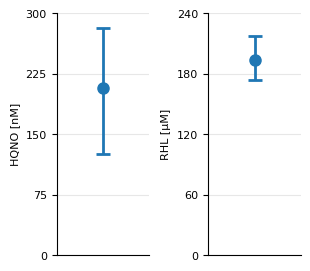

In [2]:
#load data
df_h = pd.read_csv(Path.cwd().parent / '2_gradient_inference' / 'data' / '2_hqno_diffusion_model_fits.csv')
df_r = pd.read_csv(Path.cwd().parent / '2_gradient_inference' / 'data' / '2_rhl_diffusion_model_fits.csv')

# Example usage with original parameters
default_params = {
    'L': 50.0,          # µm, chamber length
    'd': 3.0,           # µm, gap length
    'W': 50.0,          # µm, chamber width
    'W_gap': 12.5       # µm, gap width (0.25 * W)
}

c_in_h = calculate_c_in_from_dataframe(
    df_h, **default_params,
    percentiles=[5, 25, 50, 75, 95])

c_in_r = calculate_c_in_from_dataframe(
    df_r, **default_params,
    percentiles=[5, 25, 50, 75, 95])    

print_results(c_in_h, label='HQNO', unit='nM')
print_results(c_in_r, label='RHL', unit='µM')


final_width_in = 8 / 2.54
final_height_in = 7 / 2.54
font_size = 8
plt.rcParams.update({
    'font.size': font_size,
    'pdf.fonttype': 42,
    'ps.fonttype': 42
})

OUTPUT_PDF = Path.cwd() / 'figures' / '1_exogenous_concentration_estimate.pdf'
# Create bar plot with error bars for c_in values
fig, ax = plt.subplots(1,2, figsize=(final_width_in, final_height_in))
plot_c_in_summary(ax[0], c_in_h, label='HQNO [nM]', ylims=(0, 300), font_size=font_size)
plot_c_in_summary(ax[1], c_in_r, label='RHL [µM]', ylims=(0, 240), font_size=font_size)
fig.savefig(OUTPUT_PDF, bbox_inches='tight')



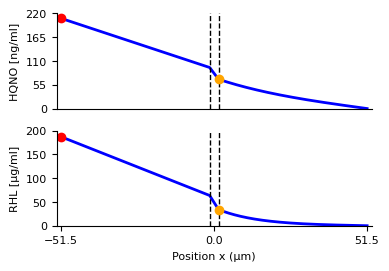

In [3]:

final_width_in = 10 / 2.54
final_height_in = 7 / 2.54
font_size = 8
plt.rcParams.update({
    'font.size': font_size,
    'pdf.fonttype': 42,
    'ps.fonttype': 42
})

# plot concentration profiles using median parameters
to_plot = {'HQNO [ng/ml]': df_h, 'RHL [µg/ml]': df_r}          
fig, ax = plt.subplots(2,1, figsize=(final_width_in, final_height_in))
for axi, (label, df_plot) in zip(ax.flatten(), to_plot.items()):
    median_params = {
        'c0': df_plot['c0'].median(),
        'A': df_plot['A'].median(),
        'L': default_params['L'],
        'd': default_params['d'],
        'W': default_params['W'],
        'W_gap': default_params['W_gap']
    }
    plot_profile(axi, median_params)
    axi.set_xlabel('Position x (µm)', fontsize=font_size)
    axi.set_ylabel(label, fontsize=font_size)

ax[0].set_ylim(0, 220)
ax[0].set_yticks(np.linspace(0,220,5))
ax[1].set_ylim(0, 200)
ax[1].set_yticks(np.linspace(0,200,5))
ax[0].set_xlabel('')
ax[0].set_xticks([])
plt.tight_layout()
fig.savefig(Path.cwd() / 'figures' / '1_fitted_concentration_profiles_dual_chamber.pdf', bbox_inches='tight')
